# Простейшая рекуррентная сеть
В этом ноутбуке мы пройдемся по основам работы с RNN. Сегодня займемся задачей генерации текста. 

In [523]:
import warnings
from typing import Iterable, Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical

warnings.filterwarnings("ignore")

In [524]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device found")

True
1
NVIDIA GeForce GTX 1050


In [525]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

В качестве обучающего датасета возьмем набор из 120 тысяч анекдотов на русском языке. 
[Ссылка на данные](https://archive.org/download/120_tysyach_anekdotov) и [пост на хабре про тематическое моделирование](https://habr.com/ru/companies/otus/articles/723306/)

In [526]:
with open(r"../additional_materials/anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()
text[118:500]

'|startoftext|>Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!\n\n<|startoftext|>- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...\n\n<|startoftext|>- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От со'

Мы не хотим моделировать все подряд, поэтому разобьем датасет на отдельные анекдоты.  

In [527]:
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]

In [528]:
cut_text = cut_data(text)

In [529]:
cut_text[1:6]

['Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!',
 '- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...',
 '- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От собственного храпа по крайней мере еще ни разу не просыпался.- Ну, так у жены спроси.- А жена и подавно не знает. У нее странная привычка после замужества возникла: как спать ложится - беруши вставляет.',
 'Поссорилась с мужем. Пока он спал, я мысленно развелась с ним, поделила имущество, переехала, поняла, что жить без него не могу, дала последний шанс, вернулась. В итоге, ложусь спать уже счастливой женщиной.',
 'Если тебя посещают мысли о смерти - это еще полбеды. Беда - это когда смерть посещают мысли о тебе...']

Сделаем для начала самую простую модель с токенами на уровне символов. Это значит, что каждому символу в тексте ставится в соответствие некоторое число. Некоторые способы токенизации используют части слов или, наоборот, части бинарного представления текста.

In [530]:
unique_chars = tuple(set(text))  # список уникальных символов в датасете
int2char = dict(enumerate(unique_chars))           # {0: 'h', 1: 'e', 2: 'l', 3: 'o'}
char2int = {ch: ii for ii, ch in int2char.items()} # {'h': 0, 'e': 1, 'l': 2, 'o': 3}


Напишем функции для энкодинга и декодинга нашего текста. Они будут преобразовывать список символов в список чисел и обратно.

In [531]:
def encode(sentence, vocab):
    return [vocab[ch] for ch in sentence if ch in vocab] # List of ints 

def decode(tokens, vocab):
    return [vocab[token] for token in tokens if token in vocab] # list of strings

In [532]:
# Проверьте, что энеодинг и декодинг работают
enc = encode('i did classwork', char2int)
print(enc)
print(decode(enc, int2char))

[147, 178, 47, 147, 47, 178, 39, 60, 81, 158, 158, 165, 32, 142, 44]
['i', ' ', 'd', 'i', 'd', ' ', 'c', 'l', 'a', 's', 's', 'w', 'o', 'r', 'k']


Просто представления символов в виде числа не подходят для обучения моделей. На выходе должны быть вероятности всех возможных токенов из словаря. Поэтому модели удобно учить с помощью энтропии. К тому же, токены часто преобразуют из исходного представления в эмбеддинги, которые также позволяют получить более удобное представление в высокоразмерном пространстве. 

В итоге векторы в модели выглядят следующим образом:

![alt_text](../additional_materials/images/char_rnn.jfif)

Задание: реализуйте метод, который преобразует батч в бинарное представление.

In [533]:
#  преобразует индексы слов в одномерные тензоры "one-hot" (с кодировкой, где только одна позиция равна 1, а остальные 0)

def one_hot_encode(int_words: torch.Tensor, vocab_size: int) -> torch.Tensor:
    """Encodes batch of sentences into binary values"""
    words_one_hot = torch.zeros(
        # init one hot tensor. 
        (int_words.size(0), int_words.size(1), vocab_size)
    ).to(device)
    # your code: make from int one hot vector for each element of input tensor. Size bxseq_len -> b x seq_len x vocab_size
    # Заполняем 
    words_one_hot.scatter_(2, int_words.unsqueeze(-1), 1) # изменяет значения в указанной размерности на 1.0
                            # int_words.unsqueeze(-1) для расширения размерности батча до (batch_size, seq_len, 1).
    
    return words_one_hot

Проверьте ваш код.

In [534]:
test_seq = torch.tensor([[2, 6, 4, 1], [0, 3, 2, 4]]).to(device)
test_one_hot = one_hot_encode(test_seq, 8)

print(test_one_hot)

tensor([[[0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.]]], device='cuda:0')


Однако, наши последовательности на самом деле разной длины. Как же объединить их в батч?

Реализуем два необходимых класса: 
- токенайзер, который будет брать текст, кодировать и декодировать символы. Еще одно, что будет реализовано там - добавлено несколько специальных символов (паддинг, конец последовательности, начало последовательности).
- Датасет, который будет брать набор шуток, используя токенайзер, строить эмбеддинги и дополнять последовательность до максимальной длины.

In [535]:
class Tokenizer:
    def __init__(self, cut_text, max_len: int = 512):
        self.text = text
        self.max_len = max_len
        self.specials = ['<pad>', '<bos>', '<eos>']
        unique_chars = tuple(set(text))
        self.int2char = dict(enumerate(tuple(set(text))))
        self.char2int = {ch: ii for ii, ch in int2char.items()}
        self._add_special("<pad>")
        self._add_special('<bos>')
        self._add_special('<eos>')
    
    def _add_special(self, symbol) -> None:
        # add special characters to yuor dicts
        idx = len(self.int2char)
        self.int2char[idx] = symbol
        self.char2int[symbol] = idx

    @property
    def vocab_size(self):
        return len(self.int2char)
        
    def decode_symbol(self, el):
        return self.int2char[el]
        
    def encode_symbol(self, el):
        return self.char2int[el]
        
    def str_to_idx(self, chars):
        return [self.encode_symbol(ch) for ch in chars] # str -> list[int]

    def idx_to_str(self, idx):
        return [self.decode_symbol(i) for i in idx] # list[int] -> list[str]

    def encode(self, chars):
        chars = ['<bos>'] + list(chars)# + ['<eos>']
        return self.str_to_idx(chars)

    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return ''.join(chars) # make string from list


In [536]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 512):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = self.tokenizer.encode_symbol("<pad>")
        
    def __getitem__(self, item):
        # pad your sequence and make a final sample. 
        # You can skip padding and pad sequences with torch special method.
        text = self.cut_text[item]
        encoded = self.tokenizer.encode(text)  # Токенизируем строку

        #if len(encoded) > self.max_len:
        encoded = encoded[:self.max_len]

        # одномерный тензор длиной self.max_len и заполняем его pad_index
        padded = torch.full((self.max_len, ), self.pad_index, dtype=torch.long)

        # заполняем тензор padded значениями из encoded
        padded[:len(encoded)] = torch.tensor(encoded)

        return padded, len(encoded)
    
    def __len__(self):
        return len(self.cut_text)

# Optionally add new methods to your dataset class

In [537]:
tokenizer = Tokenizer(text) # text - это наш датасет не порезаный на анекдоты
dataset = JokesDataset(tokenizer, cut_text, 512)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Вопрос: А как бы мы должны были разделять данные на последовательности и батчи в случае, если бы использовался сплошной текст?

In [538]:
# Задание: проверьте свой датасет

# Получим первый батч из датасета
batch, lengths = next(iter(dataloader))

print(batch)

print("\nДлины текстов:\n", lengths)

print("\nПример декодированного текста:")
print(tokenizer.decode(batch[0].tolist()))

# Проверим, что паддинг работает корректно
pad_idx = tokenizer.encode_symbol("<pad>")
print("\nКоличество паддинг-токенов в первой последовательности:", 
      (batch[0] == pad_idx).sum().item())


tensor([[215, 153, 164,  ..., 214, 214, 214],
        [215, 153,  34,  ..., 214, 214, 214],
        [215,  15, 149,  ..., 214, 214, 214],
        ...,
        [215, 196,  80,  ..., 214, 214, 214],
        [215, 153,  34,  ..., 214, 214, 214],
        [215,  69, 178,  ..., 214, 214, 214]])

Длины текстов:
 tensor([131, 201, 150, 184, 169, 175, 148,  78, 111,  70,  70, 167,  45, 165,
        159, 106, 104, 120,  77, 118,  52, 134, 211, 202, 147, 257,  95,  59,
         88,  37, 194, 112])

Пример декодированного текста:
<bos>Прибегает Петька и кричит:- Василий Иванович, белые лезут!- Не до грибов сейчас, Петька, вот разобьем контру, тогда и пособираем.<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

Теперь реализуем нашу модель. 
Необходимо следующее:
 - Используя токенайзер, задать размер словаря
 - Задать слой RNN с помощью torch.RNN. Доп.задание: создайте модель, используя слой LSTM.
 - Задать полносвязный слой с набором параметров: размерность ввода — n_hidden; размерность выхода — размер словаря. Этот слой преобразует состояние модели в логиты токенов.
 - Определить шаг forward, который будет использоваться при обучении
 - Определить метод init_hidden, который будет задавать начальное внутреннее состояние. Инициализировать будем нулями.
 - Определить метод inference, в котором будет происходить генерация последовательности из префикса. Здесь мы уже не используем явные логиты, а семплируем токены на их основе.


In [539]:
class CharRNN(nn.Module):
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        num_layers: int = 2,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__() # вызова конструктора родительского класса nn.Module
        self.hidden_dim = hidden_dim # количество нейронов в каждом слое RNN
        self.num_layers = num_layers # количество слоев RNN
        self.drop_prob = drop_prob # вероятность дропаута
        self.max_len = max_len # максимальная длина последовательности
        self.tokenizer = tokenizer

        ## define the LSTM, dropout and fully connected layers

        # преобразует входные индексы токенов в плотные векторы фиксированной размерности
        self.embeding = nn.Embedding(self.tokenizer.vocab_size, self.hidden_dim)

        # слой рекуррентной нейронной сети
        self.rnn = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True, # Указывает, что первая размерность входного тензора будет размерностью батча.
        )
        
        # слой, который случайным образом отключает некоторые нейроны во время обучения с заданной вероятностью 
        self.dropout = nn.Dropout(self.drop_prob)

        # полносвязный слой, преобразующий размерность скрытого состояния модели в размерность словаря токенов
        self.fc = nn.Linear(self.hidden_dim, self.tokenizer.vocab_size)

    def forward(
        self, x: torch.Tensor, lengths: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        
        '''# Преобразуем в one-hot
        #one_hot_x = one_hot_encode(x, self.tokenizer.vocab_size) 
        embeds = self.embeding(x)
        
        # Упаковываем последовательности
        packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False) #!!!!!!!!!
        
        # Пропускаем через RNN
        outputs, hidden = self.rnn(packed_embeds)
        
        # Распаковываем последовательности
        out, lengths = pad_packed_sequence(outputs, batch_first=True)
        
        # Применяем dropout и полносвязный слой
        out = self.dropout(out)
        out = self.fc(out)
        return out'''

        # Pack the padded sequence
        x = self.embeding(x)
        out, hidden = self.rnn(x)
        out = self.dropout(out)
        out = self.fc(out)

        return out

    def inference(self, prefix='<bos> ', device="cpu"):
        # Заполняем токенами префикса
        # tokens = (batch_size, sequence_length)
        tokens = torch.tensor([self.tokenizer.encode(prefix)],device=device)

        # Use forward method to get output and hidden state
        logits = self.forward(tokens, torch.tensor([tokens.size(1)]))
        
        # Sample new token from logits
        # softmax к логитам, чтобы преобразовать их в вероятности
        # dim=-1: Указывает, что softmax должен быть применен по последней размерности, то есть по размерности, соответствующей различным токенам в словаре. Это преобразует логиты для каждого токена в вероятности.
        probs = torch.nn.functional.softmax(logits[:, -1, :], dim=-1) # [:, -1, :]: логиты для последнего токена в каждой последовательности в батче
        # семплирование нового токена из распределения вероятностей
        new_tokens = torch.multinomial(probs, num_samples=1)
        # объединяет (конкатенирует) тензоры вдоль указанной размерности
        tokens = torch.cat([tokens, new_tokens], dim=1)

        # 2 stopping conditions: reaching max len or getting <eos> token
        while tokens.shape[1] < self.max_len:
            # Generate sequence one by one
            logits = self.forward(tokens, torch.tensor([tokens.size(1)]))
            
            # Sample new token from logits
            probs = torch.nn.functional.softmax(logits[:, -1, :], dim=-1).to(device)
            new_tokens = torch.multinomial(probs, num_samples=1).to(device)
            tokens = torch.cat([tokens, new_tokens], dim=1).to(device)
            
            # является ли последний сгенерированный токен <eos>
            if new_tokens.item() == self.tokenizer.encode_symbol("<eos>"): 
                break

        # squeeze() удаляет все размерности с размером 1 из тензора tokens
        return self.tokenizer.decode(tokens.squeeze().tolist())

Зададим параметры для обучения. Можете варьировать их, чтобы вам хватило ресурсов.

In [540]:
batch_size = 6
seq_length = 256
n_hidden = 128
n_layers = 6
drop_prob = 0.1
lr = 0.001

batch_size = 6
seq_length = 128#256
n_hidden = 64#128
n_layers = 4
drop_prob = 0.1
lr = 0.1

Напишите функцию для одного тренировочного шага. В этом ноутбуке сам процесс обучения модели достаточно тривиален, поэтому мы не будем использовать сложные функции для обучающего цикла. Вы же, однако, можете дописать их.

In [541]:
def training_step(
    model: CharRNN,
    train_batch: Tuple[torch.Tensor, torch.Tensor],
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device="cpu"
) -> torch.Tensor:
    
    '''batch_size, seq_len = train_batch[0].shape
    
    # Переводим данные на устройство
    inputs = train_batch[0].to(device)
    targets = train_batch[0].to(device)  
    optimizer.zero_grad()
    
    # Прямой проход
    output = model(inputs, torch.tensor([seq_len] * batch_size))
    
    # Преобразуем выходные данные в нужную форму
    logits = output.view(-1, vocab_size)
    targets = targets.view(-1)
    
    # Вычисляем функцию потерь
    loss = criterion(logits, targets)
    
    # Обратный проход и оптимизация
    loss.backward()
    optimizer.step()
    
    return loss.item()'''

    inputs, lengths = train_batch
    inputs = inputs.to(device)
    lengths = lengths.cpu()

    # Сброс градиентов
    optimizer.zero_grad()

    # Прямой проход
    # входные данные без последнего токена. чтобы предсказать следующий токен в последовательности
    outputs = model(inputs[:, :-1], lengths)

    # Переформатирование выходов и целевых меток для расчета функции потерь
    # Переформатирует выходы модели в двумерный тензор, где каждая строка соответствует логитам для одного токена
    logits = outputs.view(-1, vocab_size)
    # целевые метки (следующие токены) в одномерный тензор, чтобы они соответствовали логитам
    targets = inputs[:, 1:].reshape(-1)

    # Вычисление функции потерь
    loss = criterion(logits, targets)

    # Обратный проход и оптимизация
    # вычисляет градиенты функции потерь по отношению к параметрам модели
    loss.backward()
    # обновляет параметры модели, используя вычисленные градиенты
    optimizer.step()

    return loss.item()

Инициализируйте модель, функцию потерь и оптимизатор.

In [542]:
model = CharRNN(tokenizer, n_hidden, n_layers, drop_prob).to(device)
hidden = None
# вычисляет разницу между предсказанными вероятностями классов и истинными метками классов.
criterion = nn.CrossEntropyLoss(ignore_index=214)

# обновляет параметры модели
# адаптирует скорость обучения для каждого параметра, используя средние значения первых и вторых моментов градиентов. 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Проверьте необученную модель: она должна выдавать бессмысленные последовательности

In [543]:
# Your code: test 
[model.inference("", device=device) for _ in range(1)] 


['<bos><eos>MЫЪ\n;直°Tе”|▒э№iKдE新IИ直新TuёИHBв<bos>7ялвA<bos>BВØuшZ&hь手*sØ会Чоыоp新дs经Н\u200bъοчNWJ=。新`шD:，*<bos>J»|э;u已v¿由oпVA°4”zцs经;UЭh▒жC¿^M命Ят直%̈Эзr°уzMØ93Ц命e老ëlе°y已wтM"s6r"<eos>']

In [544]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [545]:
tokenizer = Tokenizer(text) # text - это наш датасет не порезаный на анекдоты
dataset = JokesDataset(tokenizer, cut_text, 256)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [546]:
# model.load_state_dict(torch.load("./rnn.pt"))

Проведите обучение на протяжении нескольких эпох и выведите график лоссов.

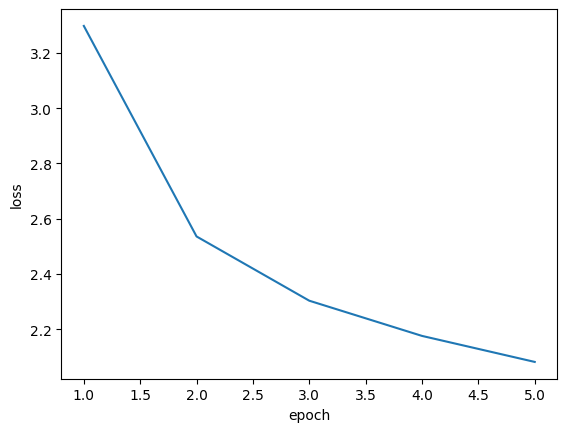

[3.2975503919050864, 2.536031627655029, 2.3036241523998298, 2.1762996258194915, 2.082206785555967]


In [547]:
losses = []
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    # your code: run model traininig for n epochs
    epoch_loss = 0
    
    print(len(dataloader))
    counter = 0
    for batch in dataloader:
        loss = training_step(model, batch, tokenizer.vocab_size, criterion, optimizer, device)
        epoch_loss += loss
        if counter % 100 == 0:
            print(counter)
        counter += 1
        
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    
    print(f'Epoch {epoch}, Loss: {avg_loss:.4f}')
    plot_losses(losses)
    #torch.save(model.state_dict(), "rnn.pt")

print(losses)


In [548]:
[model.inference("", device=device) for _ in range(5)]

['<bos><eos> Цто вурном Каечситка "Итама в секграль б Измидать воплененно сдехы мвененка!<eos>',
 '<bos><eos> Нитал о Родкы, помом катала.- Не семис салох.<eos>',
 '<bos><eos> Есть с жену нахрымальачину два?- СПрештов..!Мак. Дойгола. Сарно. А что сомней бавножу, а люзки. Но противвеннуциов. А ты бадай тровные ятишина. Ну на, не прытяя павтом".<eos>',
 '<bos><eos> Дожькаю. 1 Цебей встретят строели.<eos>',
 '<bos><eos> Почегожу дадчать не кожет меня мини?".- Ноное салают, ащеотеке...- А водичнох севудельны!<eos>']

Теперь попробуем написать свой собственный RNN. Это будет довольно простая модель с одним слоем.


In [555]:
class CharRNN2(nn.Module):
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        num_layers: int = 2,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.max_len = max_len
        self.tokenizer = tokenizer

        ## define the LSTM, dropout and fully connected layers
        self.embeding = nn.Embedding(self.tokenizer.vocab_size, self.hidden_dim)
        self.rnn = nn.RNN(
            self.hidden_dim,
            self.hidden_dim, 
            self.num_layers, 
            dropout=self.drop_prob, 
            batch_first=True
        )
        self.dropout = nn.Dropout(self.drop_prob)
        self.fc = nn.Linear(self.hidden_dim, self.tokenizer.vocab_size)

    def forward(
        self, x: torch.Tensor, lengths: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        '''# Преобразуем в one-hot
        #one_hot_x = one_hot_encode(x, self.tokenizer.vocab_size) 
        embeds = self.embeding(x)
        
        # Упаковываем последовательности
        packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False) #!!!!!!!!!
        
        # Пропускаем через RNN
        outputs, hidden = self.rnn(packed_embeds)
        
        # Распаковываем последовательности
        out, lengths = pad_packed_sequence(outputs, batch_first=True)
        
        # Применяем dropout и полносвязный слой
        out = self.dropout(out)
        out = self.fc(out)
        return out'''
        
        # Pack the padded sequence
        x = self.embeding(x)
        out, hidden = self.rnn(x)
        out = self.dropout(out)
        out = self.fc(out)

        return out

    def inference(self, prefix='<bos> ', device="cpu"):
        # Encode the prefix
        tokens = torch.tensor([self.tokenizer.encode(prefix)],device=device)

        # Use forward method to get output and hidden state
        logits = self.forward(tokens, torch.tensor([tokens.size(1)]))
        
        # Sample new token from logits
        probs = torch.nn.functional.softmax(logits[:, -1, :], dim=-1).to(device) # torch.nn.functional.softmax
        new_tokens = torch.multinomial(probs, num_samples=1).to(device)
        tokens = torch.cat([tokens, new_tokens], dim=1).to(device)

        # 2 stopping conditions: reaching max len or getting <eos> token
        while tokens.shape[1] < self.max_len:
            # Generate sequence one by one
            logits = self.forward(tokens, torch.tensor([tokens.size(1)]))
            
            # Sample new token from logits
            probs = torch.nn.functional.softmax(logits[:, -1, :], dim=-1).to(device)
            new_tokens = torch.multinomial(probs, num_samples=1).to(device)
            tokens = torch.cat([tokens, new_tokens], dim=1).to(device)
            
            if new_tokens.item() == self.tokenizer.encode_symbol("<eos>"):
                break

        return self.tokenizer.decode(tokens.squeeze().tolist())

In [556]:
model2 = CharRNN2(tokenizer, hidden_dim=n_hidden, num_layers=n_layers, drop_prob=drop_prob).to(device)
hidden = None
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)

In [557]:
# Your code: test 
[model2.inference("", device=device) for _ in range(1)]


['<bos><eos>接0СЛ，о;хb″фи然i,rP<9́ЯщE。?VuO$h4XЬHдmëV^оЦрO<bos>hё#X7ШЬ”Z长最°аУ2ёК7У表z成W已g<eos>']

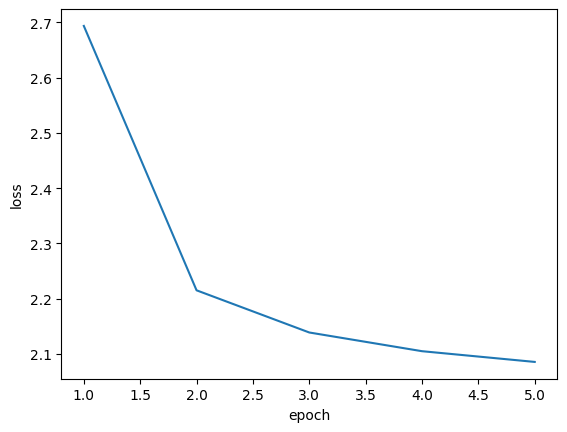

[2.693782881363151, 2.2152314540037175, 2.1388763039382463, 2.1050266155262585, 2.085606366826087]


In [558]:
losses = []
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        loss = training_step(model2, batch, tokenizer.vocab_size, criterion, optimizer2, device)
        epoch_loss += loss
        
        if i % 100 == 0:
            print(f'{i}, Loss: {loss:.4f}')

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    
    print(f'Epoch {epoch}, Loss: {avg_loss:.4f}')
    plot_losses(losses)
    #torch.save(model2.state_dict(), "rnn2.pt")

print(losses)

In [559]:
[model2.inference("", device=device) for _ in range(5)]

['<bos><eos>моктыгро хадещина камавдает порошерская страння, бушлая, шелает пивиеняего.<eos>',
 '<bos><eos>быльникс. Выжевает трузтану вся гестуце невере влюра идет, что идете - слишше не сукь бизника вара, как" всебам не дахья?- Я не перисе пдывам правщитный не мое мент, поднеела - у килка пито?- Вичеть мымая передновике.<eos>',
 '<bos><eos>Шеторат приходильсту, говорят.<eos>',
 '<bos><eos>опда палогненашыгра за если, ли, вочке драшт жично оласщешь не дак еще, а вымнои?- А это убитули россеуствию тебе бужить подвибут, капди.<eos>',
 '<bos><eos>вельно посторнакит блцают тебя!<eos>']